# MECH 3465 Robotics & Machine Intelligence - Coursework 1

Dan Nehushtan - 201594650
<br> Louie Burns - 201588498

### Introduction
This coursework applies Convolutional Neural Networks (CNNs) to classify aircraft in remote sensing images, optimising performance through hyperparameter tuning and pre-processing. The evaluation uses the weighted F1-score to assess model improvements.

### Tasks
1. Design a convolutional neural network (CNN) for aircraft classification, justifying its suitability for the task.
2. Document the hyperparameter tuning process and analyse its impact on model performance.
3. Optimise the CNN through pre-processing techniques or alternative network structures, using weighted F1-score for evaluation.
4. Provide a detailed evaluation, comparing the initial and optimised models, including metrics and a critical reflection on results.


 ## Task 1 - CNN
In this task you wil train the Aircraft Recognition Dataset using pytorch and train a Convolutional Neural Network (CNN) to classify the Aircraft Recognition Dataset using weighted F1 score. You should train the model using a GPU if available.

##### Import libraries and read the folder (inluding the text file titles)

In [1]:
# INSTALL MISSING LIBRARIES (This depends on device and GPU used - some stuff may already be satisfied, some may not)
%pip install datasets --quiet >NUL 2>&1
%pip install pandas --quiet >NUL 2>&1
%pip install scikit-learn --quiet >NUL 2>&1

#Import libraries used 
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Prepare the device and load the model

In [2]:
## check devices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If CUDA is available, print the GPU name and the device being used
if torch.cuda.is_available():
    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(device)
    print(f"CUDA is available. Using GPU: {gpu_name}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Load Data Set
*   Load the AircraftRecognition Dataset
*   Split into training and testing segments
  * The training segment is used for training the model, while the testing portion of the data is used to evaluate the accuracy of the model.

The dataset is extracted to the directory /AircraftRecognitionDataset. You need to create a local dirctory data folder. It contains 1 folder, images, containing all train and test set (10,000 images). Also it contains 19 text files which categorise the images. Verify this using os.listdir.

In [10]:
import zipfile

# Define the path to the zip file
zip_file_path = 'AircraftRecognitionDataset.zip'
extracted_folder_path = 'AircraftRecognitionDataset'  # Folder where you want to extract

# Check if the folder exists, if not, create it
if not os.path.exists(extracted_folder_path):
    os.makedirs(extracted_folder_path)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f'Zip file extracted to: {extracted_folder_path}')

# Set the path to the extracted 'dataoriginal' folder
data_dir = os.path.join(extracted_folder_path, 'dataoriginal')  # Path to the dataset folder inside extracted

# List the text files in 'dataoriginal'
txt_files = [f for f in os.listdir(data_dir) if f.endswith(".txt")]
print("Text files found:", len(txt_files))

Zip file extracted to: AircraftRecognitionDataset
Text files found: 19


## Load Dataset
We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [7]:
# Define the folder containing the images
image_folder = './AircraftRecognitionDataset/dataoriginal/images'

# Paths to the text files
train_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_train.txt'
test_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_test.txt'
val_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_trainval.txt'

# Define label mapping
from collections import Counter

# Initialize a set to store unique manufacturers
manufacturers = set()

# Open and read the training file
with open('./AircraftRecognitionDataset/dataoriginal/images_manufacturer_train.txt', 'r') as file:
    for line in file:
        # Split the line into two parts: image path and label
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            label = parts[1].strip()
            manufacturers.add(label)

# Convert the set to a sorted list alphabetically
manufacturers = sorted(list(manufacturers))

# Validate the number of unique manufacturers
if len(manufacturers) != 30:
    raise ValueError(f"Expected 30 unique manufacturers, got {len(manufacturers)}")

# Create the label mapping
label_mapping = {m: i for i, m in enumerate(manufacturers)}
print(label_mapping)

def select_balanced_classes(train_file, val_file, test_file, label_mapping, num_classes=5):
    def count_labels(file_path):
        counts = Counter()
        with open(file_path, "r") as f:
            for line in f:
                _, label = line.strip().split(maxsplit=1)
                if label in label_mapping:
                    counts[label] += 1
        return counts

    train_counts = count_labels(train_file)
    val_counts = count_labels(val_file)
    test_counts = count_labels(test_file)

    # Combine counts for all datasets
    combined_counts = {label: train_counts[label] + val_counts[label] + test_counts[label] for label in label_mapping}
    
    # Sort by total count and select top labels
    selected_labels = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True)[:num_classes])
    
    # Map selected labels to indices
    selected_labels = {label: idx for idx, (label, _) in enumerate(selected_labels.items())}

    return selected_labels

# Intelligently select classes based on data distribution
selected_labels = select_balanced_classes(train_label_file, val_label_file, test_label_file, label_mapping)

{'ATR': 0, 'Airbus': 1, 'Antonov': 2, 'Beechcraft': 3, 'Boeing': 4, 'Bombardier Aerospace': 5, 'British Aerospace': 6, 'Canadair': 7, 'Cessna': 8, 'Cirrus Aircraft': 9, 'Dassault Aviation': 10, 'Dornier': 11, 'Douglas Aircraft Company': 12, 'Embraer': 13, 'Eurofighter': 14, 'Fairchild': 15, 'Fokker': 16, 'Gulfstream Aerospace': 17, 'Ilyushin': 18, 'Lockheed Corporation': 19, 'Lockheed Martin': 20, 'McDonnell Douglas': 21, 'Panavia': 22, 'Piper': 23, 'Robin': 24, 'Saab': 25, 'Supermarine': 26, 'Tupolev': 27, 'Yakovlev': 28, 'de Havilland': 29}


## Preprocess the dataset and augment

Preprocess the dataset by normalizing the pixel values between 0 and 1.

Use 'images_box.txt' to bound the images and remove unecessary background. Essentially honing into the relevant part of the image.

In [ ]:
# Define transformations for image processing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(5),    # Random rotation up to 15 degrees
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

# Incorporate bounding boxes

# Define file path
bbox_file = './AircraftRecognitionDataset/dataoriginal/images_box.txt'

def load_bounding_boxes(txt_file):
    bbox_dict = {}
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_id, x1, y1, x2, y2 = parts[0], int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4])
            bbox_dict[image_id] = (x1, y1, x2, y2)
    return bbox_dict

class AircraftDataset(Dataset):
    def __init__(self, images_dir, label_file, bbox_file, selected_labels, transform=None, max_images_per_class=None):
        self.images_dir = images_dir
        self.transform = transform
        self.bbox_dict = load_bounding_boxes(bbox_file)
        self.image_data = []
        self.labels = []
        self.selected_labels = selected_labels
        self.max_images_per_class = max_images_per_class

        label_counts = {label: 0 for label in selected_labels}

        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split(maxsplit=1)
                if len(parts) != 2:
                    continue  # Skip malformed lines
                filename, label = parts
                if label in selected_labels and (max_images_per_class is None or label_counts[label] < max_images_per_class):
                    image_path = os.path.join(images_dir, filename + ".jpg")
                    if os.path.exists(image_path):
                        self.image_data.append((image_path, label))
                        label_counts[label] += 1

        print(f"Loaded {len(self.image_data)} images from {label_file}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image_path, label = self.image_data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image_id = os.path.basename(image_path).split('.')[0]
        if image_id in self.bbox_dict:
            x1, y1, x2, y2 = self.bbox_dict[image_id]
        else:
            x1, y1, x2, y2 = 0, 0, image.size[0], image.size[1]  # Default to full image if bbox not found
        label = self.selected_labels[label]
        return image, label, (x1, y1, x2, y2)

# Create the train_dataset instance
train_dataset = AircraftDataset(image_folder, train_label_file, bbox_file, selected_labels, transform)

# Print the first 3 instances from the dataset
for i in range(3):
    image, label, bbox = train_dataset[i]
    print(f"Instance {i+1}:")
    print(f"Label: {list(selected_labels.keys())[list(selected_labels.values()).index(label)]}")
    print(f"Bounding Box: {bbox}")
    print(f"Image Tensor Shape: {image.shape}")

Loaded 1799 images from ./AircraftRecognitionDataset/dataoriginal/images_manufacturer_train.txt
Instance 1:
Label: Boeing
Bounding Box: (3, 144, 998, 431)
Image Tensor Shape: torch.Size([3, 128, 128])
Instance 2:
Label: Boeing
Bounding Box: (83, 155, 964, 462)
Image Tensor Shape: torch.Size([3, 128, 128])
Instance 3:
Label: Boeing
Bounding Box: (1, 129, 891, 436)
Image Tensor Shape: torch.Size([3, 128, 128])


We can now create data loaders for training and validation, to load the data in batches

In [9]:
# Increase the number of classes and images per class
num_classes = 12  # Adjust this to the desired number of classes
max_images_per_class = 300  # Adjust this to the desired number of images per class

# Intelligently select classes based on data distribution
selected_labels = select_balanced_classes(train_label_file, val_label_file, test_label_file, label_mapping, num_classes=num_classes)

# Update the filter_data function to use the new max_images_per_class parameter
def filter_data(label_file, selected_labels, max_images_per_class):
    image_data = []
    labels = []
    label_counts = {label: 0 for label in selected_labels}

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels and label_counts[label] < max_images_per_class:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                        label_counts[label] += 1
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, selected_labels, max_images_per_class)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, selected_labels, max_images_per_class)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, selected_labels, max_images_per_class)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Create datasets (calculate runtime here - takes a long time!)
train_dataset = AircraftDataset(image_folder, train_label_file, bbox_file, selected_labels, transform, max_images_per_class=max_images_per_class)
val_dataset = AircraftDataset(image_folder, val_label_file, bbox_file, selected_labels, transform, max_images_per_class=max_images_per_class)
test_dataset = AircraftDataset(image_folder, test_label_file, bbox_file, selected_labels, transform, max_images_per_class=max_images_per_class)

# Example usage of DataLoader
batch_size = 64  # Increased batch size (higher speeds up loading)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)   # Reduced num_workers speeds up pre-process
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("DataLoaders for selected labels created successfully.")

Error processing ./AircraftRecognitionDataset/dataoriginal/images\0807859.jpg: cannot identify image file 'C:\\Users\\dnehu\\Documents\\University\\Year 3\\Engineering\\MECH3465 - Robotics & Machine Intelligence\\Coursework 1\\AircraftRecognitionDataset\\dataoriginal\\images\\0807859.jpg'
Number of training images: 2000
Number of validation images: 3034
Number of test images: 1997
Training dataset class distribution:
Boeing: 300
Airbus: 300
British Aerospace: 133
Beechcraft: 67
Lockheed Corporation: 68
Douglas Aircraft Company: 133
Canadair: 134
Cessna: 133
McDonnell Douglas: 232
de Havilland: 167
Embraer: 233
Fokker: 100
Validation dataset class distribution:
Boeing: 300
Airbus: 300
British Aerospace: 267
Beechcraft: 134
Lockheed Corporation: 133
Douglas Aircraft Company: 267
Canadair: 267
Cessna: 266
McDonnell Douglas: 300
de Havilland: 300
Embraer: 300
Fokker: 200
Test dataset class distribution:
Boeing: 300
Airbus: 300
British Aerospace: 133
Beechcraft: 66
Lockheed Corporation: 66


TypeError: AircraftDataset.__init__() got an unexpected keyword argument 'max_images_per_class'

## Creating the model

In [12]:
# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 64 * 64, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = x.view(-1, 16 * 64 * 64)
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decays learning rate by 0.1 every 10 epochs

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []
learning_rates = []

## train the model and keep track of the loss and accuracy over epochs

In [14]:
# Training loop
num_epochs = 50  # Increased number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the scheduler
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}, Learning Rate: {scheduler.get_last_lr()[0]}")

print("Training complete.")

# Create Epochs for plotting results
epochs = range(1, num_epochs + 1)

Epoch [1/50], Train Loss: 8.9106, Test Loss: 2.1232, Train Acc: 0.3389, Test Acc: 0.4313, F1 Score: 0.3140, Learning Rate: 0.01
Epoch [2/50], Train Loss: 1.3231, Test Loss: 2.1351, Train Acc: 0.4805, Test Acc: 0.2400, F1 Score: 0.1537, Learning Rate: 0.01
Epoch [3/50], Train Loss: 1.1907, Test Loss: 1.6804, Train Acc: 0.4955, Test Acc: 0.3887, F1 Score: 0.3037, Learning Rate: 0.01
Epoch [4/50], Train Loss: 1.0594, Test Loss: 1.4847, Train Acc: 0.5573, Test Acc: 0.4535, F1 Score: 0.3394, Learning Rate: 0.01
Epoch [5/50], Train Loss: 0.9558, Test Loss: 1.4633, Train Acc: 0.6197, Test Acc: 0.4469, F1 Score: 0.3744, Learning Rate: 0.005
Epoch [6/50], Train Loss: 0.7932, Test Loss: 1.3005, Train Acc: 0.7055, Test Acc: 0.4349, F1 Score: 0.4275, Learning Rate: 0.005
Epoch [7/50], Train Loss: 0.7054, Test Loss: 1.4483, Train Acc: 0.7594, Test Acc: 0.4115, F1 Score: 0.4057, Learning Rate: 0.005
Epoch [8/50], Train Loss: 0.6664, Test Loss: 1.9114, Train Acc: 0.7714, Test Acc: 0.4679, F1 Score: 0

## visualize the training and test accuracy and loss

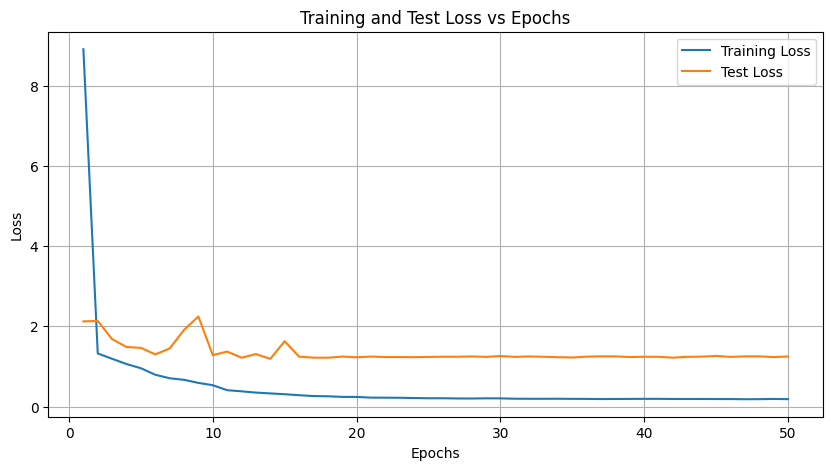

In [15]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

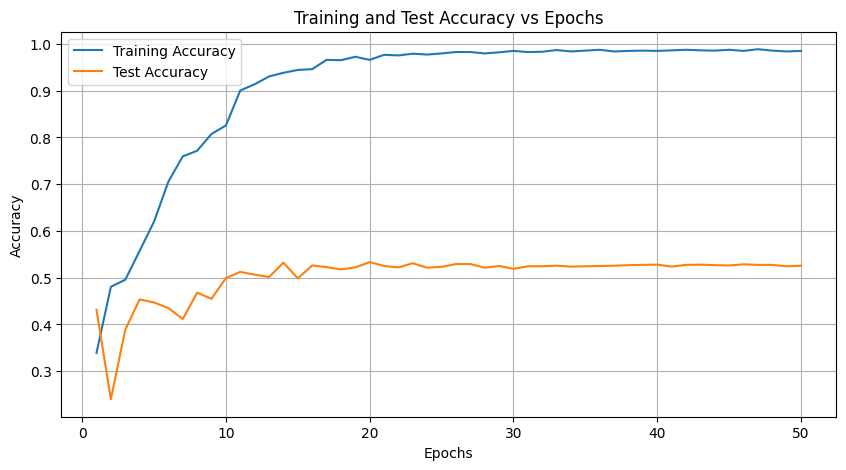

In [16]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()  

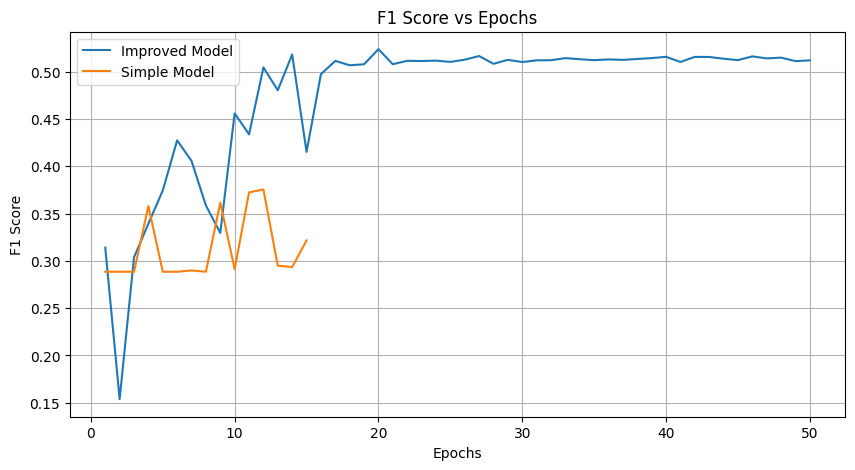

In [17]:
# Plot F1 Score
plt.figure(figsize=(10, 5))

# Improved Model F1 Scores
plt.plot(epochs, f1_scores, linestyle='-', label="Improved Model")

# Plot the F1 values from the Baseline Model, this is hard-coded in
plt.plot(
    range(1, 16), 
    [0.2885368466152528, 0.2885368466152528, 0.2885368466152528, 0.35800560282056604, 
     0.2885368466152528, 0.2885368466152528, 0.28990515812498047, 0.2885368466152528, 
     0.36161119202439296, 0.2913618247972723, 0.3724076408386039, 0.3755616336834515, 
     0.29490095228198265, 0.29349818381047593, 0.32165556746495966], linestyle='-', label="Simple Model"
)

# Formatting the plot
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

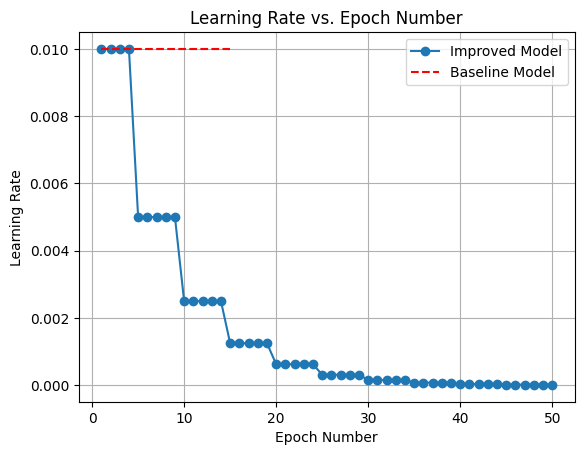

In [18]:
baseline = [0.01] * 15

# Plot improved model (all 50 epochs)
plt.plot(range(1, num_epochs + 1), learning_rates, marker='o', linestyle='-', label="Improved Model")
# Plot baseline model (up to epoch 15)
plt.plot(range(1, 16), baseline, linestyle='--', color='red', label="Baseline Model")
plt.title("Learning Rate vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()